In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import scanpy as sc
import os
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import torch
import scipy.sparse as sp
import anndata as ad

import warnings
warnings.filterwarnings("ignore")

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

plt.rcParams['font.size'] = 12

# Load data

In [2]:
sp_data = sc.read('../datas/mouse_hypothalamus/GSE113576_Moffitt_and_Bambah-Mukku_et_al_merfish.h5ad')
sp_data

AnnData object with n_obs × n_vars = 485657 × 161
    obs: 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID'
    obsm: 'spatial'

In [3]:
sp_data = sp_data[(sp_data.obs.Animal_ID == 1) & (sp_data.obs.Bregma == 0.26), ]
sp_data

View of AnnData object with n_obs × n_vars = 5584 × 161
    obs: 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID'
    obsm: 'spatial'

In [4]:
sc_data = sc.read('../datas/mouse_hypothalamus/GSE113576_scrna.h5ad')
sc_data

AnnData object with n_obs × n_vars = 31299 × 27998
    obs: 'Sex', 'Replicate number', 'Cell class (determined from clustering of all cells)', 'Non-neuronal cluster (determined from clustering of all cells)', 'Neuronal cluster (determined from clustering of inhibitory or excitatory neurons)', 'cell_type'
    var: 'gene_ids', 'feature_types'

In [8]:
sc_data.obs['cell_type'] = sc_data.obs['Cell class (determined from clustering of all cells)']

# Process data

In [5]:
# Convert to row-sparse matrix
if not sp.issparse(sc_data.X):
    sc_data.X = sp.csr_matrix(sc_data.X)
    
if not sp.issparse(sp_data.X):
    temp = sp.csr_matrix(np.array(sp_data.X)).copy()
    del sp_data.X
    sp_data.X = temp.copy()
    del temp

In [6]:
# Please make sure cell_type is included in scRNA_data.obs
assert 'cell_type' in sc_data.obs

In [7]:
sp_data = sp_data[sp_data.obs['Cell_class'] != 'Ambiguous', ]
sp_data

View of AnnData object with n_obs × n_vars = 4832 × 161
    obs: 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID'
    obsm: 'spatial'

In [8]:
cell_type_map = {
    'Astrocyte': 'Astrocytes',
    'Inhibitory': 'Inhibitory',
    'OD Mature 2': 'Mature oligodendrocyte',
    'Endothelial 1': 'Endothelial',
    'Pericytes': 'Mural',
    'Endothelial 2': 'Endothelial',
    'OD Mature 1': 'Mature oligodendrocyte',
    'OD Immature 1': 'Immature oligodendrocyte',
    'Excitatory': 'Excitatory',
    'Microglia': 'Microglia',
    'Endothelial 3': 'Endothelial',
    'OD Mature 4': 'Mature oligodendrocyte',
    'OD Immature 2': 'Immature oligodendrocyte',
    'OD Mature 3': 'Mature oligodendrocyte',
    'Ependymal': 'Ependymal'
}

sp_data.obs['cell_type'] = sp_data.obs['Cell_class'].replace(cell_type_map)
sp_data.obs

,Animal_ID,Animal_sex,Behavior,Bregma,Centroid_X,Centroid_Y,Cell_class,Neuron_cluster_ID,cell_type
0,1,Female,Naive,0.26,-3211.562145,2608.541476,Astrocyte,NaN,Astrocytes
1,1,Female,Naive,0.26,-3207.923151,2621.795437,Inhibitory,I-5,Inhibitory
2,1,Female,Naive,0.26,-3209.578004,2633.153494,Inhibitory,I-6,Inhibitory
3,1,Female,Naive,0.26,-3203.853515,2756.045983,Inhibitory,I-5,Inhibitory
4,1,Female,Naive,0.26,-3202.682705,2608.803635,Inhibitory,I-9,Inhibitory
...,...,...,...,...,...,...,...,...,...
5579,1,Female,Naive,0.26,-1430.494998,3594.782213,Astrocyte,NaN,Astrocytes
5580,1,Female,Naive,0.26,-1574.375277,4183.177498,Inhibitory,I-6,Inhibitory
5581,1,Female,Naive,0.26,-1531.108030,4181.272965,Endothelial 1,NaN,Endothelial
5582,1,Female,Naive,0.26,-1475.241835,4185.236063,Inhibitory,I-1,Inhibitory


In [13]:
# Convert spatial coordinates to integers
sp_data.obsm['spatial'] = np.round(sp_data.obsm['spatial']).astype(int)

In [9]:
# # Find common cell types
common_cell_type = list(set(sp_data.obs['cell_type'].tolist()) & set(sc_data.obs['cell_type'].tolist()))
common_cell_type

['Astrocytes',
 'Excitatory',
 'Inhibitory',
 'Mature oligodendrocyte',
 'Mural',
 'Endothelial',
 'Ependymal',
 'Immature oligodendrocyte',
 'Microglia']

In [10]:
sp_data = sp_data[sp_data.obs['cell_type'].isin(common_cell_type), :]
sp_data

View of AnnData object with n_obs × n_vars = 4832 × 161
    obs: 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID', 'cell_type'
    obsm: 'spatial'

In [11]:
sc_data = sc_data[sc_data.obs['cell_type'].isin(common_cell_type), :]
sc_data

View of AnnData object with n_obs × n_vars = 29760 × 27998
    obs: 'Sex', 'Replicate number', 'Cell class (determined from clustering of all cells)', 'Non-neuronal cluster (determined from clustering of all cells)', 'Neuronal cluster (determined from clustering of inhibitory or excitatory neurons)', 'cell_type'
    var: 'gene_ids', 'feature_types'

# Run code

In [12]:
import sys
sys.path.append('../')

import SpCAST
from SpCAST.utils import preprocess_datasets

In [14]:
scRNA_data = sc_data.copy()
spRNA_data = sp_data.copy()

del scRNA_data.raw
del spRNA_data.raw

In [15]:
import os
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

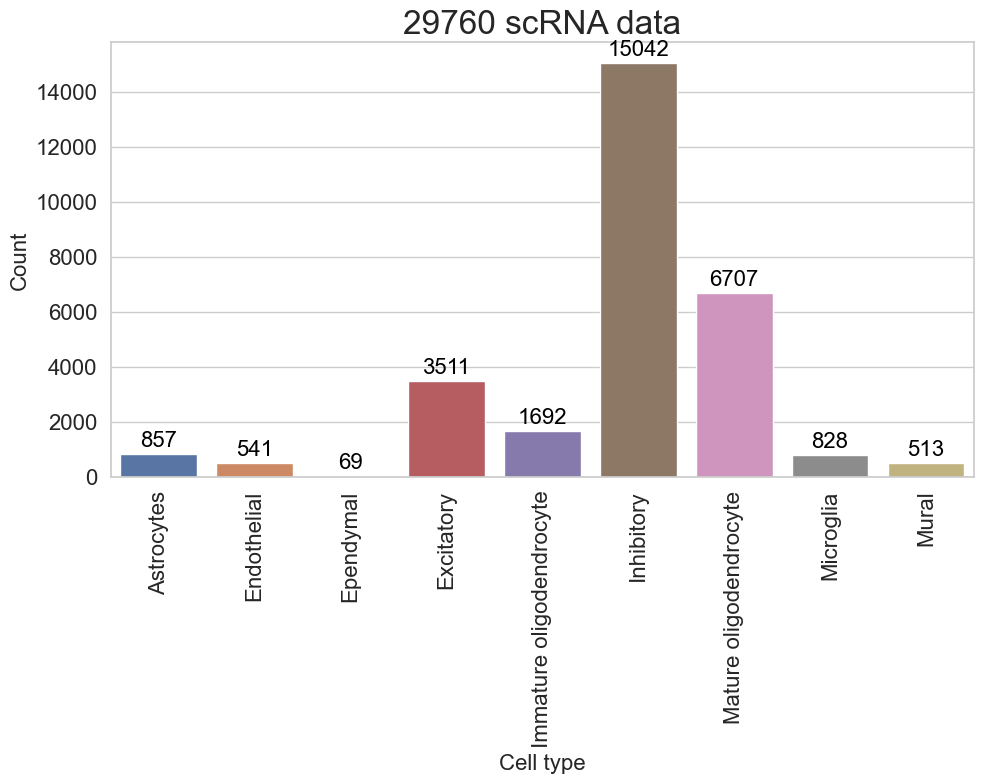

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Calculate the count for each category
sc_category_counts = scRNA_data.obs['cell_type'].value_counts().reset_index()
sc_category_counts.columns = ['Category', 'Count']

plt.figure(figsize=(10, 8))

# Draw barplot
ax = sns.barplot(x='Category', y='Count', data=sc_category_counts)

# Add title and labels
plt.title(f'{len(scRNA_data.obs)} scRNA data', fontsize=24)
plt.xlabel('Cell type', fontsize=16)
plt.ylabel('Count', fontsize=16)

# Rotate x-axis labels
plt.xticks(rotation=90, fontsize=16)

# Increase font size for y-axis ticks
plt.yticks(fontsize=16)

# Add count labels on the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=16, color='black', 
                xytext=(0, 5), 
                textcoords='offset points')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [17]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

datatype = 'FISH'
assert datatype in ['FISH', 'Seq']
scRNA_data, spRNA_data = preprocess_datasets(scRNA_data, spRNA_data, final_n_top_genes=2000, min_genes_in_cells=3, datatype=datatype)

Preprocessing scRNA-seq data ...
scRNA Data before filtering: 29760 cells  ||  scRNA Data after filtering: 29676 cells
Normalizing and log1p raw scRNA counts...
sc data nonzero expression ratio: 13.24%
-----------------------------------------------
Preprocessing spRNA-seq data ...
spRNA Data already normalized. Skipping normalization.
-----------------------------------------------
sp data nonzero expression ratio: 33.64%
Concatenating datasets...
We have 153 shared genes on scRNA and spatial RNA data
Computing scRNA data marker genes ...
We ultimately use 153 genes for training ...
Preprocessing completed...


In [18]:
save_model_path='../model'
save_model_name='model_params.pth'

prob_df = SpCAST.train_SpCAST(scRNA_data=scRNA_data, spRNA_data=spRNA_data,
                              latent_dim1=30, latent_dim2=20, 
                              batch_size=256, loss_step=1, n_epochs=10, device=device, 
                              save_model_path=save_model_path, save_model_name=save_model_name)

Size of scRNA-seq data Input:  (29676, 153)
Size of spRNA-seq data Input:  (4832, 153)
Class distribution: [  825   534    69  3509  1681 15025  6696   824   513]
Class weights: [0.11218209 0.11993786 0.1773526  0.0923003  0.10144159 0.07834455
 0.08553141 0.11220233 0.12070726]
Train the model..........


Training:  10%|███████▎                                                                 | 1/10 [00:00<00:07,  1.22it/s]

Epoch:1 MMD Loss:8.547  Class Loss:38.788  Recon loss: 37456.648  Train_Accuracy: 49.24% 


Training:  20%|██████████████▌                                                          | 2/10 [00:01<00:05,  1.59it/s]

Epoch:2 MMD Loss:7.792  Class Loss:28.262  Recon loss: 36417.130  Train_Accuracy: 68.83% 


Training:  30%|█████████████████████▉                                                   | 3/10 [00:01<00:03,  1.76it/s]

Epoch:3 MMD Loss:6.218  Class Loss:18.159  Recon loss: 33759.137  Train_Accuracy: 68.54% 


Training:  40%|█████████████████████████████▏                                           | 4/10 [00:02<00:03,  1.88it/s]

Epoch:4 MMD Loss:5.397  Class Loss:13.285  Recon loss: 29728.418  Train_Accuracy: 74.65% 


Training:  50%|████████████████████████████████████▌                                    | 5/10 [00:02<00:02,  1.95it/s]

Epoch:5 MMD Loss:5.087  Class Loss:10.646  Recon loss: 25370.009  Train_Accuracy: 84.29% 


Training:  60%|███████████████████████████████████████████▊                             | 6/10 [00:03<00:01,  2.01it/s]

Epoch:6 MMD Loss:4.655  Class Loss:7.936  Recon loss: 21086.010  Train_Accuracy: 91.26% 


Training:  70%|███████████████████████████████████████████████████                      | 7/10 [00:03<00:01,  2.04it/s]

Epoch:7 MMD Loss:4.350  Class Loss:6.161  Recon loss: 17493.775  Train_Accuracy: 93.42% 


Training:  80%|██████████████████████████████████████████████████████████▍              | 8/10 [00:04<00:00,  2.05it/s]

Epoch:8 MMD Loss:4.011  Class Loss:4.614  Recon loss: 15090.200  Train_Accuracy: 94.63% 


Training:  90%|█████████████████████████████████████████████████████████████████▋       | 9/10 [00:04<00:00,  2.06it/s]

Epoch:9 MMD Loss:3.844  Class Loss:4.085  Recon loss: 13478.197  Train_Accuracy: 94.86% 


Training: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.94it/s]

Epoch:10 MMD Loss:3.692  Class Loss:3.677  Recon loss: 12420.776  Train_Accuracy: 94.98% 
Testing the model..........



Testing scRNA data: 100%|███████████████████████████████████████████████████████████| 116/116 [00:00<00:00, 181.53it/s]


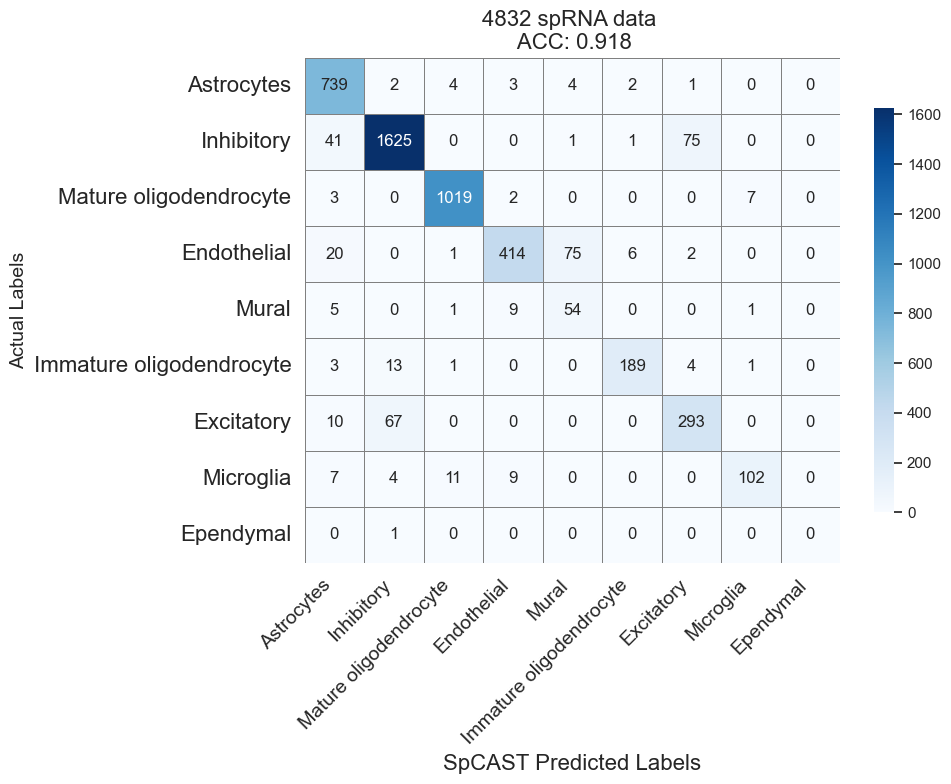

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# Get unique category labels
cell_labels = spRNA_data.obs['cell_type'].unique().tolist()

spRNA_data.obs.cell_type = spRNA_data.obs.cell_type.astype(str)
spRNA_data.obs.SpCAST_predicted = spRNA_data.obs.SpCAST_predicted.astype(str)

# Calculate confusion matrix
conf_matrix = confusion_matrix(spRNA_data.obs['cell_type'], spRNA_data.obs['SpCAST_predicted'], labels=cell_labels)

# Convert confusion matrix to DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, index=cell_labels, columns=cell_labels)

# Plot heatmap
plt.figure(figsize=(10, 8))  # Increase figure size
sns.heatmap(conf_matrix_df, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            cbar_kws={'shrink': 0.8},  # Shrink color bar
            linewidths=0.5,  # Add grid line width
            linecolor='grey')  # Set grid line color

# Add axis labels and title
plt.xlabel('SpCAST Predicted Labels', fontsize=16)
plt.ylabel('Actual Labels', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=14)  # Rotate x-axis labels
plt.yticks(rotation=0, fontsize=16)  # Keep y-axis labels horizontal

# Calculate accuracy and update the title
accuracy = accuracy_score(spRNA_data.obs['cell_type'], spRNA_data.obs['SpCAST_predicted'])
f1 = f1_score(spRNA_data.obs['cell_type'], spRNA_data.obs['SpCAST_predicted'], average='macro')

plt.title(f'{len(spRNA_data.obs)} spRNA data \n ACC: {accuracy:.3f}', fontsize=16)
# Display the plot
plt.tight_layout()  # Automatically adjust subplot parameters to fit the figure
plt.show()

# Identify marker genes

In [42]:
biomarkers = {
    "Inhibitory": ["Gad1"],
    "Excitatory": ["Slc17a6"],
    "Mature oligodendrocyte": ["Ttyh2"],
    "Immature oligodendrocyte": ["Pdgfra"],
    "Astrocytes": ["Aqp4"],
    "Microglia": ["Selplg"],
    "Ependymal": ["Cd24a"],
    "Endothelial": ["Fn1"],
    "Mural": ["Myh11"]
}

In [61]:
scRNA_data.obs['cell_type'].astype('category').cat.categories.tolist()

['Astrocytes',
 'Endothelial',
 'Ependymal',
 'Excitatory',
 'Immature oligodendrocyte',
 'Inhibitory',
 'Mature oligodendrocyte',
 'Microglia',
 'Mural']

In [62]:
biomarkers_list = []

for k in scRNA_data.obs['cell_type'].astype('category').cat.categories.tolist():
    biomarkers_list.extend(biomarkers[k])
biomarkers_list

['Aqp4',
 'Fn1',
 'Cd24a',
 'Slc17a6',
 'Pdgfra',
 'Gad1',
 'Ttyh2',
 'Selplg',
 'Myh11']

Compute SHAP values using DeepExplainer ...


100%|██████████| 4832/4832 [23:52<00:00,  3.37it/s]


Complete compute ...


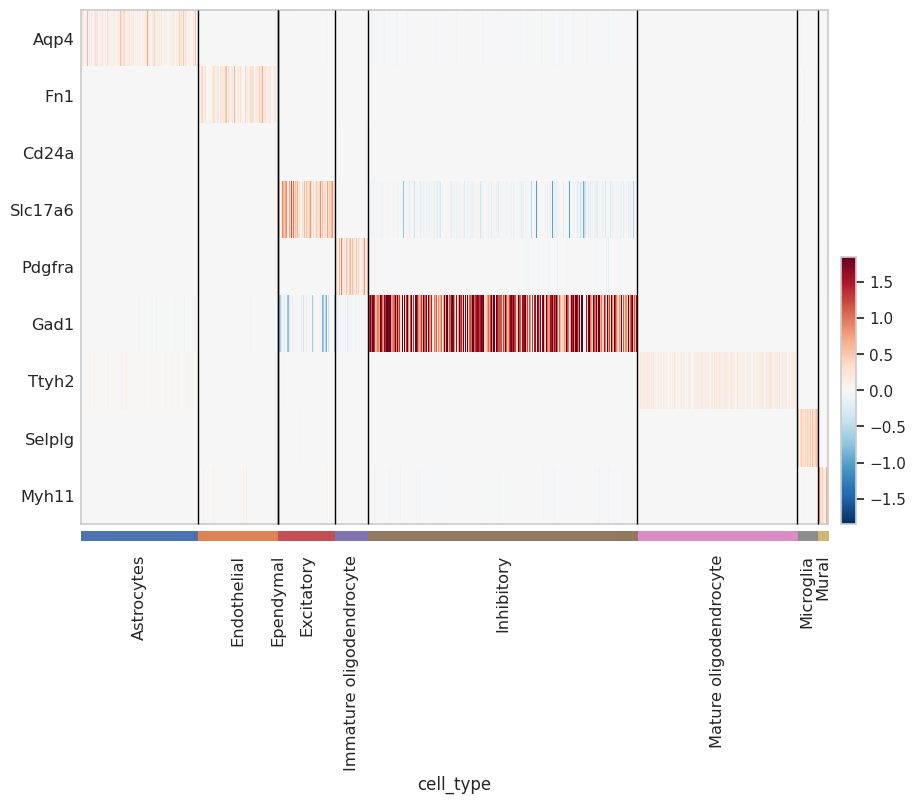

In [63]:
from SpCAST.visualization import feature_importance_identification

shap_values_df = feature_importance_identification(scRNA_data, spRNA_data, biomarkers_list=biomarkers_list, device=device, batch_size=1, 
                                                      save_model_path=save_model_path, save_model_name=save_model_name)